<a href="https://colab.research.google.com/github/hyelimchoi1223/wanted_pre_onboarding_project/blob/main/assignment/week2/4%ED%8C%80_%EC%B5%9C%ED%98%9C%EB%A6%BC_Week2_2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week2_2 Assignment

## [BASIC](#Basic) 
- "네이버 영화 감성 분류" 데이터를 불러와 `pandas` 라이브러리를 사용해 **전처리** 할 수 있다.
- 적은 데이터로도 높은 성능을 내기 위해, pre-trained `BERT` 모델 위에 1개의 hidden layer를 쌓아 **fine-tuning**할 수 있다.

## [CHALLENGE](#Challenge)
- 토큰화된 학습 데이터를 배치 단위로 갖는 **traindata iterator**를 구현할 수 있다. 

## [ADVANCED](#Advanced)
- **loss와 optimizer 함수**를 사용할 수 있다. 
- traindata iterator를 for loop 돌며 **fine-tuning** 할 수 있다.
- fine-tuning의 2가지 방법론을 비교할 수 있다. 
  - BERT 파라미터를 **freeze** 한 채 fine-tuning (Vision에서 주로 사용하는 방법론)
  - BERT 파라미터를 **unfreeze** 한 채 fine-tuning (NLP에서 주로 사용하는 방법론)


### Reference
- [huggingface 한국어 오픈소스 모델](https://huggingface.co/models?language=ko&sort=downloads&search=bert)
- [transformer BertForSequenceClassification 소스 코드](https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/models/bert/modeling_bert.py#L1501)

In [ ]:
import os
import sys
import pandas as pd
import numpy as np 
import torch
import random

In [ ]:
# seed
seed = 7777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# device type
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"# available GPUs : {torch.cuda.device_count()}")
  print(f"GPU name : {torch.cuda.get_device_name()}")
else:
  device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


## Basic

### 데이터 다운로드 및 DataFrame 형태로 불러오기
- 내 구글 드라이브에 데이터를 다운받은 후 코랩에 드라이브를 마운트하면 데이터를 영구적으로 사용할 수 있음.
- [네이버영화감성분류](https://github.com/e9t/nsmc)
  - trainset: 150,000 
  - testset: 50,000 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/경력파일/4. 프리온보딩/Week2_2_assignment_data"

/content/drive/MyDrive/경력파일/4. 프리온보딩/Week2_2_assignment_data


In [ ]:
# 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [ ]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")
_DATA_DIR = os.path.join(_CUR_DIR, "nsmc")

My current directory : /content/drive/MyDrive/경력파일/4. 프리온보딩/Week2_2_assignment_data


In [ ]:
# nsmc/ratings_train.txt를 DataFrame 형태로 불러오기
data_path= "/content/drive/MyDrive/경력파일/4. 프리온보딩/Week2_2_assignment_data/nsmc/ratings_train.txt"
df = pd.read_csv(data_path, sep="\t")

In [ ]:
# 데이터 크기 확인
df.shape

(150000, 3)

In [ ]:
# 데이터 일부 확인
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 결측치 제거 및 데이터 수 줄이기 
- 학습 데이터 수는 150,000개로 매우 많은 양이다. 하지만 우리가 실생활에서 마주할 데이터는 이렇게 많지 않다. 이 때 유용하게 사용되는 것이 **fine-tuning** 학습 방법이다.   
- Fine-tuning은 단어의 의미를 이미 충분히 학습한 모델 (여기서는 **BERT**)을 가져와 그 위에 추가적인 Nueral Network 레이어를 쌓은 후 학습하는 방법론이다. 이미 BERT가 단어의 의미를 충분히 학습했기 때문에 **적은 데이터**로 학습해도 우수한 성능을 낼 수 있다는 장점이 있다. 
- **데이터의 label의 비율이 5:5를 유지하면서** 학습 데이터 수를 150,000개에서 1,000개로 줄이는 함수 `label_evenly_balanced_dataset_sampler`를 구현하라.
  - 함수 정의 
    - 입력 매개변수
      - df : DataFrame
      - n_sample : df에서 샘플링할 row의 개수 (여기서는 1000개로 정의한다)
    - 조건
      - label의 비율이 5:5를 유지할 수 있도록 샘플링한다.
    - 반환값
      - row의 개수가 1000개인 dataframe

In [ ]:
df.isnull().sum(axis = 0)

id          0
document    5
label       0
dtype: int64

document에 결측치가 발견되었으므로 결측치는 제거한다.

In [ ]:
# df에서 결측치 (na 값) 제거

df = df.dropna(axis=0, how='any')

성공적으로 제거가 되었다.

In [ ]:
df.isnull().sum(axis = 0)

id          0
document    0
label       0
dtype: int64

In [ ]:
# label별 데이터 수 확인
# pandas의 value_counts 함수 활용
# 0 -> 부정 1 -> 긍정
df.value_counts(subset='label')

label
0    75170
1    74825
dtype: int64

In [ ]:
# 학습 데이터 샘플 개수 설정

n_sample = 1000

In [ ]:
# 샘플링 함수 구현
# random 모듈에서 제공되는 함수 활용
# input: 학습 데이터 샘플 개수
# output: 샘플링 데이터


def label_evenly_balanced_dataset_sampler(df, sample_size):
  """
  데이터 프레임의을 sample_size만큼 임의 추출해 새로운 데이터 프레임을 생성.
  이 때, "label"열의 값들이 동일한 비율을 갖도록(5:5) 할 것.
  """
  return df.groupby('label').sample(n=n_sample//2, random_state=seed)

sample_df = label_evenly_balanced_dataset_sampler(df, n_sample)

In [ ]:
# 검증

sample_df.label.value_counts()

0    500
1    500
Name: label, dtype: int64

### CustomClassifier 클래스 구현
<img src="https://github.com/ChristinaROK/PreOnboarding_AI_assets/blob/36a670a7b6233d5218a495150beb337a899ecb70/week2/week2_2_bertclf.png?raw=true" width=400>

- 그림과 같이 사전 학습(pre-trained)된 `BERT` 모델을 불러와 그 위에 **1 hidden layer**와 **binary classifier layer**를 쌓아 fine-tunning 모델을 생성할 것이다.    
---
- hidden layer 1개와 output layer(binary classifier layer)를 갖는 `CustomClassifier` 클래스를 구현하라.
- 클래스 정의
  - 생성자 입력 매개변수
    - `hidden_size` : BERT의 embedding size
    - `n_label` : class(label) 개수
  - 생성자에서 생성할 변수
    - `bert` : BERT 모델 인스턴스 
    - `classifier` : 1 hidden layer + relu +  dropout + classifier layer를 stack한 `nn.Sequential` 모델
      - 첫번재 히든 레이어 (첫번째 `nn.Linear`)
        - input: BERT의 마지막 layer의 1번재 token ([CLS] 토큰) (shape: `hidden_size`)
        - output: (shape: `linear_layer_hidden_size`)
      - 아웃풋 레이어 (두번째 `nn.Linear`)
        - input: 첫번째 히든 레이어의 아웃풋 (shape: `linear_layer_hidden_size`)
        - output: target/label의 개수 (shape:2)
  - 메소드
    - `forward()`
      - BERT output에서 마지막 레이어의 첫번째 토큰 ('[CLS]')의 embedding을 가져와 `self.classifier`에 입력해 아웃풋으로 logits를 출력함.
  - 주의 사항
    - `CustomClassifier` 클래스는 부모 클래스로 `nn.Module`을 상속 받는다.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# classifier 구현
class CustomClassifier(nn.Module):

  def __init__(self, hidden_size: int, n_label: int):
    super(CustomClassifier, self).__init__()

    self.bert = BertModel.from_pretrained("klue/bert-base")
    dropout_rate = 0.1
    linear_layer_hidden_size = 32
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(linear_layer_hidden_size, n_label)
    ) # torch.nn에서 제공되는 Sequential, Linear, ReLU, Dropout 함수 활용


  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
    outputs = self.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
    )
    # BERT 모델의 마지막 레이어의 첫번재 토큰을 인덱싱
    cls_token_last_hidden_states = outputs['pooler_output'] # 마지막 layer의 첫 번째 토큰 ("[CLS]") 벡터를 가져오기, shape = (1, hidden_size)
    logits = self.classifier(cls_token_last_hidden_states)

    return logits

## Challenge

### 학습 데이터를 배치 단위로 저장하는 이터레이터 함수 `data_iterator` 구현
- 데이터 프레임을 입력 받아 text를 토큰 id로 변환하고 label은 텐서로 변환해 배치만큼 잘라 (input, target) 튜플 형태의 이터레이터를 생성하는 `data_iterator` 함수를 구현하라.
- 함수 정의 
  - 입력 매개변수
    - `input_column` : text 데이터 column 명
    - `target_column` : label 데이터 column 명
    -  `batch_size` : 배치 사이즈
  - 조건
    - 함수는 다음을 수행해야 함 
      - 데이터 프레임 랜덤 셔플링
      - `tokenizer_bert`로 text를 token_id로 변환 + 텐서화 
      - target(label)을 텐서화
  - 반환값 
    - (input, target) 튜플 형태의 이터레이터를 반환

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 31.3 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
     |████████████████████████████████| 6.5 MB 61.6 MB/s 
     |████████████████████████████████| 895 kB 66.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained("klue/bert-base") # lower-cased version

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [ ]:
# 토크나이징 예시 (1개의 문장)

# 1. string type의 문장을 가져옴
ex_sent = sample_df.document.iloc[0]
print(f"Original Sentence: {ex_sent}\n")

# 2. 문장을 토크나이즈 함. 이 때, 특수 토큰 ("[CLS]", "[SPE]")을 자동으로 추가하고 pytorch의 tensor형태로 변환해 반환함
tensor_sent = tokenizer_bert(
    ex_sent,
    add_special_tokens=True, # 문장의 앞에 문장 시작을 알리는 "[CLS]"토큰, 문장의 끝에 문장 끝을 알리는 "[SPE]"토큰을 자동으로 추가
    return_tensors='pt' # pytorch tensor로 반환할 것
)
print(f"Tokenized Sentence: {tensor_sent}")

Original Sentence: 진짜 이런 영화 찍는 감독 죽이고 싶다

Tokenized Sentence: {'input_ids': tensor([[   2, 4229, 3667, 3771, 1626, 2259, 3871, 6810, 2088, 1335, 2062,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
# 토크나이징 예시 (2개의 문장)

# 1. 2개의 문장을 가진 list 생성
ex_sent_list = list(sample_df.document.iloc[:2].values)
for i, sent in enumerate(ex_sent_list):
    print(f"Original Sentence {i+1}: {sent}")

# 2. 문장 리스트를 토크나이즈 함. 이 때, 리스트 내 문장들의 토큰 길이가 동일할 수 있도록 가장 긴 문장을 기준으로 부족한 위치에 "[PAD]" 토큰을 추가
tensor_sent_list = tokenizer_bert(
    ex_sent_list,
    add_special_tokens=True,
    return_tensors='pt',
    padding="longest" # 가장 긴 문장을 기준으로 token개수를 맞춤. 모자란 토큰 위치는 "[PAD]" 토큰을 추가
)

print(f"\nTokenized Sentence list: {tensor_sent_list}")

# 토크나이즈 된 두 문장의 길이가 동일함을 검증
assert tensor_sent_list['input_ids'][0].shape == tensor_sent_list['input_ids'][1].shape 

Original Sentence 1: 진짜 이런 영화 찍는 감독 죽이고 싶다
Original Sentence 2: 솔직히 대사 몇개안했는데 발연기..같음

Tokenized Sentence list: {'input_ids': tensor([[    2,  4229,  3667,  3771,  1626,  2259,  3871,  6810,  2088,  1335,
          2062,     3,     0,     0,     0,     0],
        [    2,  7946,  5140,  1077,  2019,  2283,  2371, 13964,  1123,  2156,
          2015,    18,    18,   555,  2053,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
def data_iterator(df, input_column, target_column, batch_size):
  """
  데이터 프레임을 셔플한 후 
  데이터 프레임의 input_column을 batch_size만큼 잘라 토크나이즈 + 텐서화하고, target_column을 batch_size만큼 잘라 텐서화 하여
  (input, output) 튜플 형태의 이터레이터를 생성
  """

  global tokenizer_bert

  # 1. 데이터 프레임 셔플
  #    pandas의 sample 함수 사용
  df = df.sample(n=len(sample_df), random_state=2022)

  # 2. 이터레이터 생성
  for idx in range(0, df.shape[0], batch_size):

    batch_df = df.iloc[idx:idx+batch_size]
    tensorized_input = tokenizer_bert(list(batch_df[input_column].values),
                                      add_special_tokens=True,
                                      return_tensors='pt',
                                      padding="longest") # df의 text를 토크나이징 + token id로 변환 + 텐서화 (df의 input_column 사용)

    tensorized_target = torch.tensor(list(batch_df[target_column])) # target(label)을 텐서화 (df의 target_column 사용)
    yield tensorized_input, tensorized_target # 튜플 형태로 yield

In [ ]:
batch_size=32
train_iterator = data_iterator(sample_df, 'document', 'label', batch_size)

In [ ]:
next(train_iterator)

({'input_ids': tensor([[    2,  1530,     3,  ...,     0,     0,     0],
         [    2,   732,  1507,  ...,     0,     0,     0],
         [    2,  1637,  5212,  ...,     0,     0,     0],
         ...,
         [    2,  8136,  5543,  ...,     0,     0,     0],
         [    2, 20609,  2073,  ...,     0,     0,     0],
         [    2,   197,    66,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])},
 tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         1, 1, 0, 1, 0, 0, 1, 0]))

## Advanced

### `data_iterator` 함수로 생성한 이터레이터를 for loop 돌면서 배치 단위의 데이터를 모델에 학습하는 `train()` 함수 구현
- 함수 정의
  - 입력 매개변수
    - `model` : BERT + 1 hidden layer classifier 모델
    - `data_iterator` : train data iterator
- Reference
  - [Loss: CrossEntropyLoss official document](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  - [Optimizer: AdamW official document](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

In [ ]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from numpy.core.fromnumeric import nonzero
from tqdm import tqdm

In [ ]:
# 모델 클래스 정의
model = CustomClassifier(hidden_size=768, n_label=2)

batch_size = 32

# 데이터 이터레이터 정의 
train_iterator = data_iterator(sample_df, 'document', 'label', batch_size)

# 로스 및 옵티마이저
loss_fct = CrossEntropyLoss()
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train(model, data_iterator):

  global loss_fct # 위에서 정의한 loss 함수

  # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
  total_loss, batch_loss, batch_count = 0,0,0
  
  # model을 train 모드로 설정 & device 할당
  model.train()
  model.to(device)
  
  # data iterator를 돌면서 하나씩 학습
  step = 0
  for batch in tqdm(data_iterator):
    batch_count+=1
    
    # tensor 연산 전, 각 tensor에 device 할당
    batch = tuple(item.to(device) for item in batch)
    
    batch_input, batch_label = batch
    
    # batch마다 모델이 갖고 있는 기존 gradient를 초기화
    model.zero_grad()
    # forward
    logits = model(batch_input['input_ids'], batch_input['attention_mask'], batch_input['token_type_ids'])
    # loss
    loss = loss_fct(logits, batch_label)
    batch_loss += loss.item()
    total_loss += loss.item()
    # backward -> 파라미터의 미분(gradient)를 자동으로 계산
    loss.backward()
    
    # optimizer 업데이트
    optimizer.step()
    # 배치 10개씩 처리할 때마다 평균 loss를 출력
    if (step % 10 == 0 and step != 0):
      print(f"Step : {step}, Avg Loss : {batch_loss / batch_count:.4f}")
      
      # 변수 초기화 
      batch_loss, batch_count = 0,0

    step += 1
  
  print(f"Mean Loss : {total_loss/(step+1):.4f}")
  print("Train Finished")

### 지금까지 구현한 함수와 클래스를 모두 불러와 `train()` 함수를 실행하자
- fine-tuning 모델 클래스 (`CustomClassifier`)
    - hidden_size = 768
    - n_label = 2
- 데이터 이터레이터 함수 (`data_iterator`)
    - batch_size = 32
- loss 
    - `CrossEntropyLoss()`
- optimizer
    - optimizer는 loss(오차)를 상쇄하기 위해 파라미터를 업데이트 하는 과정
    - `optimizer.step()` 시 파라미터가 업데이트 됨 
    - lr = 2e-5
- Reference
  - [Optimizer 종류 설명 한국어 블로그 ](https://ganghee-lee.tistory.com/24)
    

In [ ]:
# 학습 시작
train(model, train_iterator)

11it [00:04,  2.55it/s]

Step : 10, Avg Loss : 0.6576


21it [00:08,  2.47it/s]

Step : 20, Avg Loss : 0.5879


32it [00:11,  2.70it/s]

Step : 30, Avg Loss : 0.5218
Mean Loss : 0.5701
Train Finished


## fine-tuning 2가지 방법론 비교
- pre-trained BERT 모델 파라미터를 **freeze**한 채 학습하라
    - BERT의 파라미터의 `requires_grad` 값을 `False`로 바꾸면, 학습 시 BERT의 파라미터는 미분이 계산되지도, 업데이트 되지도 않는다. 
    - 이렇게 특정 모델의 파라미터가 업데이트 하지 못하도록 설정하는 것을 **freeze**라고 한다. 
    - BERT 파라미터를 freeze시킨 채 학습을 진행해보자. 이럴 경우, 우리가 직접 쌓은 fine-tuning layer의 파라미터만 업데이트 된다. 
- **unfreeze**와 **freeze** 모델의 성능을 비교해 보자. 어떤 방식이 더 우수한가?

    

In [ ]:
class CustomClassifierFreezed(nn.Module):

  def __init__(self, hidden_size: int, n_label: int):
    super(CustomClassifierFreezed, self).__init__()

    self.bert = BertModel.from_pretrained("klue/bert-base")
    # freeze BERT parameter
    # BERT의 파라미터는 고정값으로 두고 BERT 위에 씌운 linear layer의 파라미터만 학습하려고 한다. 
    # 이 경우, BERT의 파라미터의 'requires_grad' 값을 False로 변경해줘야 학습 시 해당 파라미터의 미분값이 계산되지 않는다.
    for param in self.bert.parameters():
        param.requires_grad = False

    dropout_rate = 0.1
    linear_layer_hidden_size = 32

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, linear_layer_hidden_size),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(linear_layer_hidden_size, n_label)
    ) # torch.nn에서 제공되는 Sequential, Linear, ReLU, Dropout 함수 활용

      
  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

    outputs = self.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
    )
    
    # BERT 모델의 마지막 레이어의 첫번재 토큰을 인덱싱
    cls_token_last_hidden_states = outputs['pooler_output'] # 마지막 layer의 첫 번째 토큰 ("[CLS]") 벡터를 가져오기, shape = (1, hidden_size)
    logits = self.classifier(cls_token_last_hidden_states)

    return logits

In [ ]:
# freeze 모델
# model을 제외한 설정값은 위에서 실행한 unfreeze 모델과 동일
model = CustomClassifierFreezed(hidden_size=768, n_label=2)

# 데이터 이터레이터
batch_size =  32
train_iterator = data_iterator(sample_df, 'document', 'label', batch_size)

# 로스 및 옵티마이저
loss_fct = CrossEntropyLoss()
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# 학습 시작
train(model, train_iterator)

12it [00:01,  7.04it/s]

Step : 10, Avg Loss : 0.6891


22it [00:03,  6.89it/s]

Step : 20, Avg Loss : 0.6933


32it [00:04,  7.33it/s]

Step : 30, Avg Loss : 0.6935
Mean Loss : 0.6711
Train Finished


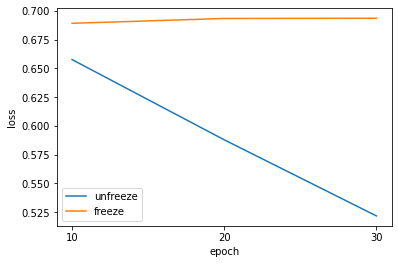

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([0.6576, 0.5879, 0.5218], label='unfreeze')
ax.plot([0.6891, 0.6933, 0.6935], label='freeze')
ax.legend()
plt.xticks(ticks=[0,1,2], labels=[10,20,30])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

unfreeze 된 모델의 loss값이 freeze된 모델보다 급격히 떨어지고 있고, 더 낮은 값을 가지고 있다.
때문에 unfreeze 된 모델이 더 우수하다.